In [1]:
import pandas as pd
import sqlalchemy 
import psycopg2
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime as dt
import sys
import boto3
import os

In [2]:
sys.path.append('..')

In [3]:
from modules.stats import *

In [4]:
#guardar paso en csv
path='/data/ETLcache/'
now = dt.now()
timestamp = now.strftime("_%d%m%Y_%H%M%S")

In [5]:
DBname=os.environ['DB_NAME']
postgres_psswd=os.environ['POSTGRES_PASSWORD']
postgres_user=os.environ['POSTGRES_USER']
postgres_port=str(os.environ['POSTGRES_PORT'])
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://'+postgres_user+':'+postgres_psswd+'@'+DBname+':'+postgres_port+'/superset')
# Create the connection
cnx = create_engine(postgres_str)

In [6]:
s="nacional"
n="consolidado_nacional"
nacional=pd.read_sql_table(n, con=cnx,schema=s)

In [7]:
def loglog(df,x,y,z,dpi=150,filename=''):
    ### DEIS-fallecidos
    deis=df.loc[~df[x].isnull(),(x,y)]
    deis=deis.rolling(7).mean()

    #dates=nacional.loc[~nacional[x].isnull(),z]
    dates=nacional[z]
    dates=dates.dt.date.astype(str)
    #dates=dates.values
    #x_ticks=dates[::50].index
    #notin=list(set(dates.index) - set(x_ticks))
    #dates.loc[notin]=None

    grid = sns.lineplot(x=x,y=y,data=deis)
    ax2 = plt.twiny()
    ax2.grid(False)
    
    sns.lineplot(x,y,data=deis, marker='o', linestyle='',ax=ax2,alpha=0)
    ax2.set(xscale="log", yscale="log",xlabel='Fecha')

    x_ticks=ax2.get_xticks()
    x_ticks=np.append(x_ticks,deis[x].max())

    grid.set(xscale="log", yscale="log",xticks=x_ticks)
    grid.grid(True,which="both",ls="-",c='white',alpha=0.8)  

    
    

    
    fechas=[]
    for xtick in x_ticks:
        #print(xtick)
        idx=(nacional[x].fillna(0)-xtick).abs().argsort()[:2][1]
        #fechas.append(nacional.loc[idx,'Fecha'])
        fechas.append(idx)
        
    fechas=dates.loc[fechas].values
    
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(fechas, rotation=45, fontsize=9)
    ax2.set_xlim(deis[x].min(), deis[x].max())
    
    grid.set_xlim(deis[x].min(), deis[x].max())
    plt.savefig(filename,dpi=dpi,bbox_inches='tight')
    
    #return dates,fechas

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


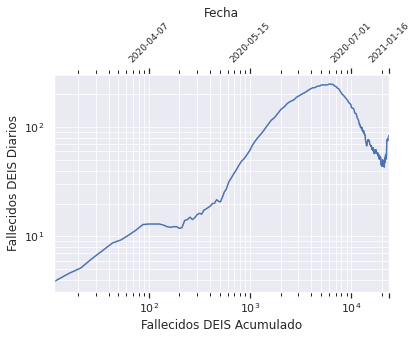

In [8]:
loglog(nacional,'Fallecidos DEIS Acumulado','Fallecidos DEIS Diarios','Fecha',dpi=100,filename=path+'Muertes_DEIS.png')

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


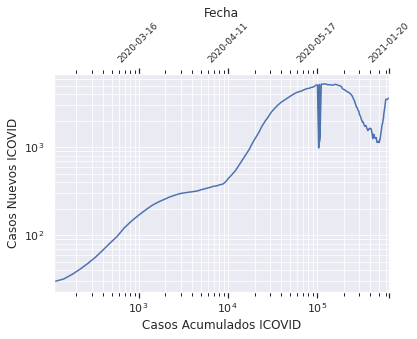

In [9]:
loglog(nacional,'Casos Acumulados ICOVID','Casos Nuevos ICOVID','Fecha',dpi=100,filename=path+'Contagios_ICOVID.png')

In [10]:
ACCESS_KEY = os.environ['S3_ACCESS_KEY']
SECRET_KEY = os.environ['S3_SECRET_KEY']
bucket=os.environ['S3_BUCKET']

In [11]:
s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
                      aws_secret_access_key=SECRET_KEY)

In [12]:
filelist= [file for file in os.listdir(path) if file.endswith('.png')]

In [13]:
filelist

['Muertes_SOCHIMI_24012021_045519.png',
 'Muertes_DEIS_24012021_050637.png',
 'Muertes_SOCHIMI_24012021_044135.png',
 'Muertes_DEIS_24012021_051414.png',
 'Muertes_SOCHIMI_24012021_051414.png',
 'Muertes_SOCHIMI_24012021_050637.png',
 'Muertes_ConfirmadosPCR+_06122020_224126.png',
 'Muertes_ConfirmadosPCR+_24012021_051644.png',
 'Muertes_SOCHIMI_24012021_051644.png',
 'Muertes_DEIS.png',
 'Muertes_ConfirmadosPCR+.png',
 'Muertes_ConfirmadosPCR+_24012021_044135.png',
 'Muertes_SOCHIMI_06122020_224126.png',
 'Muertes_DEIS_24012021_051644.png',
 'Contagios_ICOVID.png',
 'Muertes_DEIS_24012021_045519.png',
 'Muertes_DEIS_06122020_224126.png',
 'Muertes_DEIS_24012021_044135.png',
 'Muertes_ConfirmadosPCR+_24012021_045519.png',
 'Muertes_ConfirmadosPCR+_24012021_051414.png',
 'Muertes_ConfirmadosPCR+_24012021_050637.png',
 'Muertes_SOCHIMI.png']

In [14]:
for f in filelist:
    s3.upload_file(path+'/'+f, bucket, f, ExtraArgs={'ACL':'public-read'})

In [15]:
os.system('jupyter nbconvert --output /home/jovyan/work/ETLdocs/' + 'ETL_covid-chile.html' + ' --to html ' + 
          '/home/jovyan/work/ETL/covid-chile.ipynb')

65280